## Network analysis

In the [previous post](https://dadaromeo.github.io/the-voice-tweets-mining-part-1), we showed how to use Twitter API and the excellent Tweepy Python library to collect data and store them in a [MongoDB](https://www.mongodb.com/) database. It's now time to start aking questions.

Many of the questions that we ask of our tweets data can be answered through [network analysis](https://en.wikipedia.org/wiki/Social_network_analysis). Questions such as *who is important?*, *who talks to whom?*, and *what is important?* can all be answered through a network. Using proper network measures, we can find these important actors or topics in a network.

A network (or graph) is a set of *vertices* linked by a set of *edges*. Vertices are the elements that comprise a network and edges join vertices. Undirected edges join vertices in a symmetric fashion. If two people engage in a conversation, then this is best represented by an undirected edge because for user `Alice` to converse with user `Bob`, `Bob` must also converse with `Alice`.

Contrary to undirected edges are directed edges, which signify a one-way relationship between two users. `Alice` retweet relationship can be thought of as a directed edge because `Alice` can retweet `Bob` without `Bob` reciprocating.

Another property to consider is *edge weight*. The weight of an edge signifies its importance when compared to other edges. One natural usage of weighted edges is in a user mention network, where the weight is the number of times the a user say `Alice` mentions another user, `Bob`.

### Networks from tweets data

We begin by constructing a retweet network because it carries a very intuitive meaning. The nodes are individual users. The *directed* edges indicate the flow of information in the network. An edge from node $A$ to node $B$ indicates that $A$ has retweeted $B$, forwarding $B$’s information to his followers. Studying the structure of this network yields information about the ways the users communicate, and how highly they value each others’ information.

We use [Graph-tool](https://graph-tool.skewed.de/), an efficient Python module for manipulation and statistical analysis of graphs.

In [2]:
%matplotlib inline

from collections import defaultdict

import numpy as np
import graph_tool.all as gt
import pymongo

In [3]:
host = "localhost"
port = 27017

db = pymongo.MongoClient(host, port).search

The `create_network` function will help us create different kind of networks (retweet, mention, hashtag coccurence) during this analysis. It takes a set of vertices and edges and a keyword indicating the type (directed, undirected) of network.

In [4]:
font_family = "Lato Medium"
output_size = (1000, 1000)

def create_network(vertices, edges, directed=True):
    net = gt.Graph(directed=directed)
    label = net.new_vertex_property("string")
    
    vertices = list(vertices)
    net.add_vertex(len(vertices))
    
    for i,v in enumerate(net.vertices()):
        label[v] = vertices[i]
    
    for u in net.vertices():
        for v in net.vertices():
            e = (label[u], label[v])
            if edges.get(e, 0) > 0:
                net.add_edge(u, v)
    
    
    net.vertex_properties["label"] = label
    
    return net

def weight_from(net, edges, label):
    weight = net.new_edge_property("float")
    
    for e in net.edges():
        s = label[e.source()]
        t = label[e.target()]
        k = edges[(s,t)]
        weight[e] = k
    
    return weight

def pprint(net, metric, title, n=5, fmt="simple"):
    from tabulate import tabulate
    
    most = {}
    label = net.vertex_properties["label"]
    
    for v in retweet_net.vertices():
        d = metric[v]
        l = label[v]
        most[l] = d
    
    users = sorted(most, key=lambda k: most[k], reverse=True)[:n]
    top = {"": np.arange(1,n+1), title: users}
    
    tabular = tabulate(top, headers="keys", tablefmt=fmt)
    
    print(tabular)

### Retweet network

In [5]:
rvertices = set()
redges = defaultdict(int)

for tweet in db.thevoice.find():
    if "retweeted_status" in tweet.keys():
        s = "@" + tweet["user"]["screen_name"]
        rvertices.add(s)
        t = "@" + tweet["retweeted_status"]["user"]["screen_name"]
        rvertices.add(s)
        e = (s, t)
        redges[e] += 1

retweet_net = create_network(rvertices, redges)

### Centrality

Often, we want to know who is the most important person in the network. The question of importance may not be as straightforward as it seems. There are several dimensions along which one may be considered important. Measures of importance in social networks are called *centrality measures*. Three (*degree centrality*, *eigenvector centrality* and *betweeness centrality*) of these measures are the most frequently used in social media analysis. Here, we discuss the first two of them. Each provides a different view of who is important in the network. We will use the retweet network for the purpose.

#### In degree centrality - Who is the most retweeted?

One of the most commonly used centrality measures is *degree centrality*. The calculation is simple: count the number of links attached to the node, this is their degree centrality. In the case of a directed graph, there are two interpretations: *In-Degree Centrality*, the number of edges entering the node, and *Out-Degree*, the number of edges leaving the node. In the context of our retweet networks, *In-Degree Centrality* is the number of users that retweet the
node, and *Out-Degree Centrality* is the number of users the node retweets. The figure below shows such a network with our tweets data.

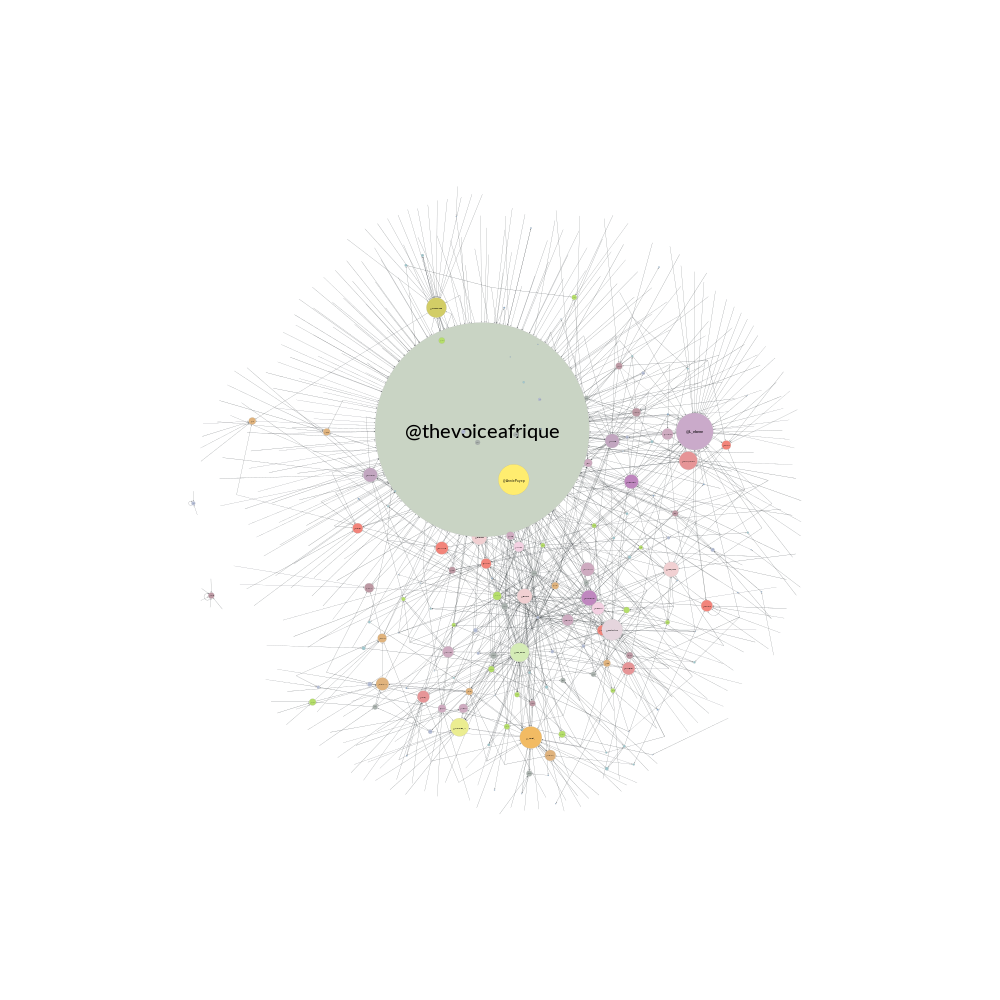

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fa6007aa8d0, at 0x7fa5e62dfba8>

In [6]:
rdeg = retweet_net.degree_property_map("in")
rlabel = retweet_net.vertex_properties["label"]

rfsize = retweet_net.new_vertex_property("float")
rfsize.a = rdeg.a / 10

rpos = gt.arf_layout(retweet_net)

gt.graph_draw(retweet_net,
              rpos,
              vertex_size=rdeg,
              vertex_text=rlabel,
              vertex_font_size=rfsize,
              vertex_fill_color=rdeg,
              vertex_font_family=font_family,
              output_size=output_size,
              )

In [7]:
pprint(retweet_net, rdeg, "Most retweeted", 10)

    Most retweeted
--  ----------------
 1  @thevoiceafrique
 2  @Jojo_Le_Doc
 3  @L_ebene
 4  @AnniePayep
 5  @_Coriet_
 6  @Fantastyck
 7  @asalfomagic
 8  @Ton_durex
 9  @Arn8ld
10  @Hermine_N


We see on the figure and the table above, without a surprise that the official page of the event, `@thevoiceafrique` is the most retweeted. We also see that the sponsor's account is amount the most retweeted. We also see that one the coaches, `@asalfomagic` is retweeted a lot. In the [topic modeling](https://dadaromeo.github.io/the-voice-afrique-tweets-mining-part-3) and [sentiment analysis](https://dadaromeo.github.io/the-voice-afrique-tweets-mining-part-4) post, we will see if we can tell more about that.

#### Egeinvector centrality - Who is the most influencial?

With Degree Centrality the key question was "how many people retweeted this node?" *Eigenvector Centrality* builds upon this to ask "how important are these retweeters?"

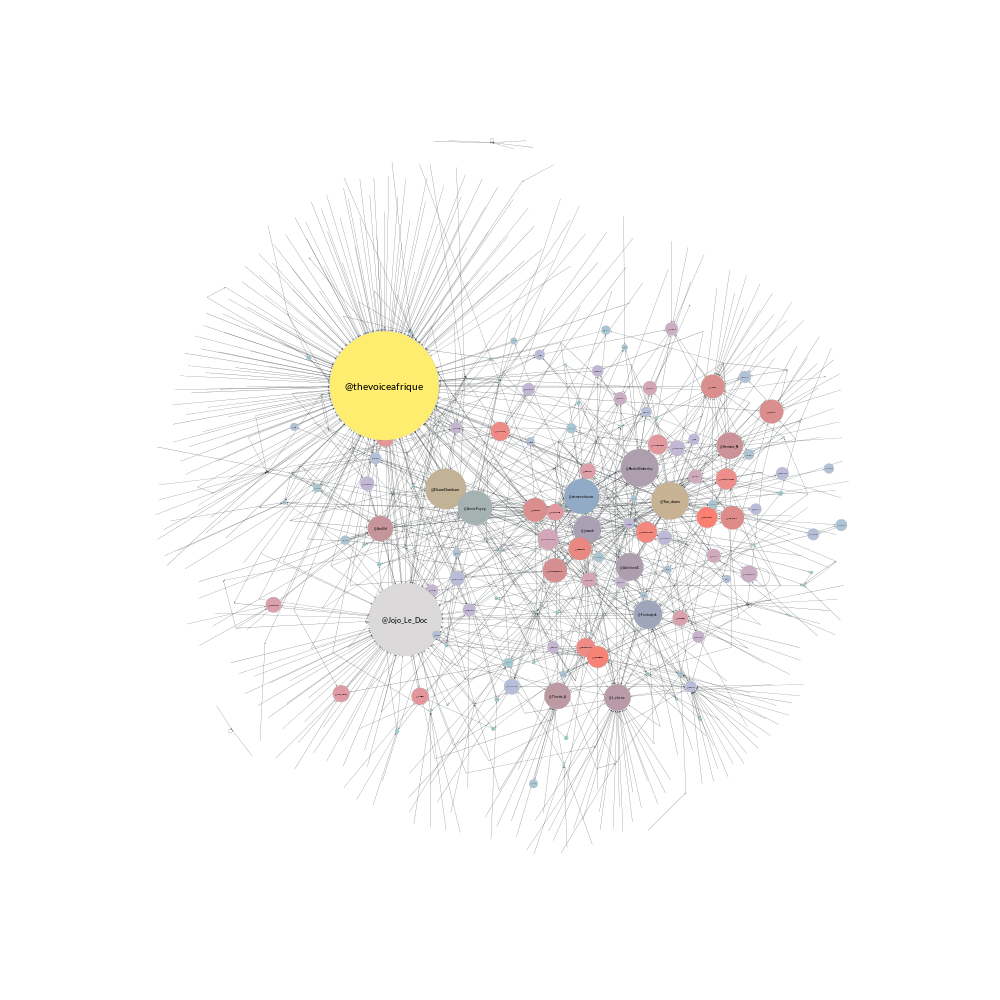

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fa6007aa8d0, at 0x7fa5e4f721d0>

In [8]:
reig = gt.eigenvector(retweet_net)[1]
reig.a *= 200

rfsize = retweet_net.new_vertex_property("float")
rfsize.a = reig.a / 10

rlabel = retweet_net.vertex_properties["label"]

rpos = gt.arf_layout(retweet_net)

gt.graph_draw(retweet_net,
              rpos,
              vertex_size=reig,
              vertex_text=rlabel,
              vertex_font_size=rfsize,
              vertex_fill_color=reig,
              vertex_font_family=font_family,
              output_size=output_size,
              )

In [9]:
pprint(retweet_net, reig, "Most influencial", 10)

    Most influencial
--  ------------------
 1  @thevoiceafrique
 2  @Jojo_Le_Doc
 3  @Ton_durex
 4  @DianeDomkam
 5  @AnniePayep
 6  @stvmvondoarts
 7  @Fantastyck
 8  @jussoch
 9  @NadiaKimberley
10  @AdelinetcC


We see in the figure and the table above that the strucutre of the network and the ranking have changed. Some users kept thier position, other downweighted, and other upweighted. We see that there are new "players" in the ranking table while others who where previously in the degree centrality table, went away, like `@L_ebene` and `@_Coriet_`.

### Mentions network

In the mention network the edges are weighted to answer the question who mentions who the most?

In [10]:
mvertices = set()
medges = defaultdict(int)

for tweet in db.thevoice.find():
    if not("retweeted_status" in tweet.keys()):
        mentions = tweet["entities"]["user_mentions"]
        if mentions:
            s = "@" + tweet["user"]["screen_name"]
            mvertices.add(s)
            for ment in mentions:
                t = "@" + ment["screen_name"]
                mvertices.add(t)
                e = (s, t)
                medges[e] += 1

mention_net = create_network(mvertices, medges)

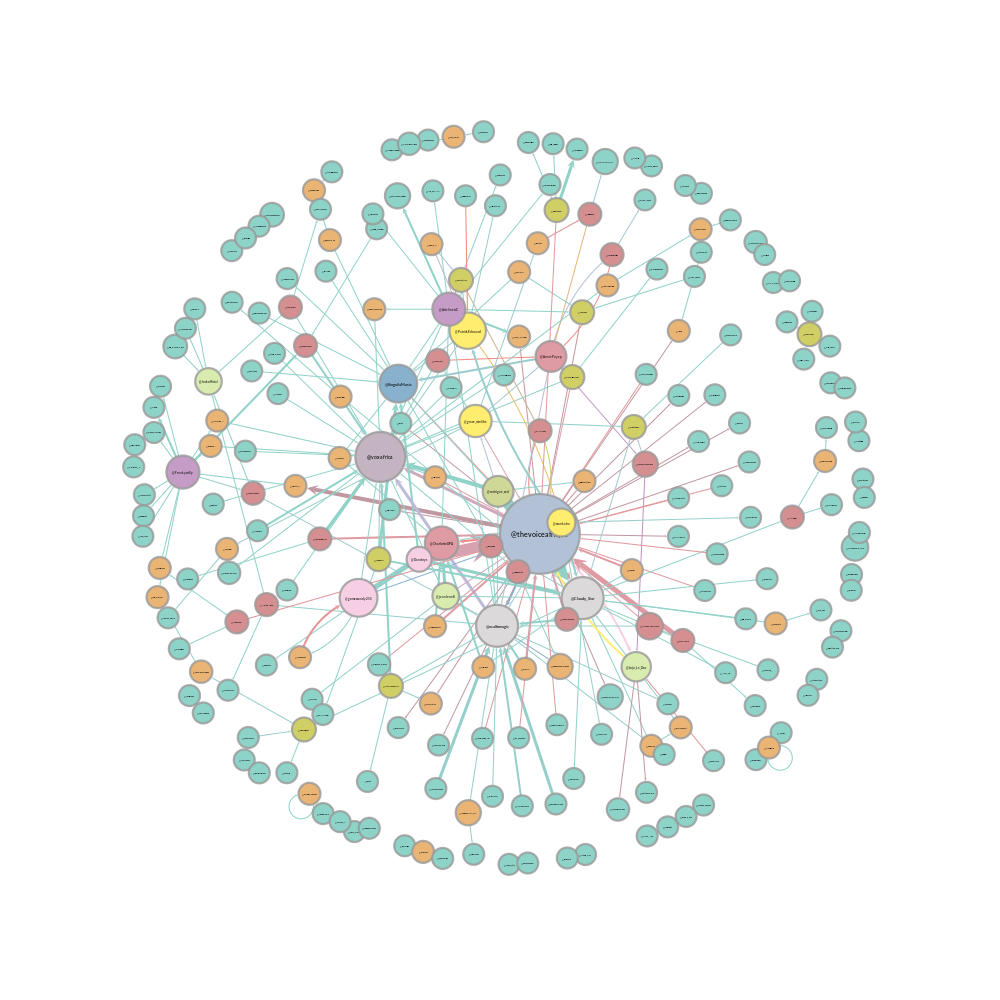

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fa5e5433e48, at 0x7fa5e57266d8>

In [11]:
mvbet, mebet = gt.betweenness(mention_net)
mlabel = mention_net.vertex_properties["label"]

mdeg = mention_net.degree_property_map("total")
mdeg.a += 20
mfsize = mention_net.new_vertex_property("float")
mfsize.a = mdeg.a / 10

mweight = weight_from(mention_net, medges, mlabel)

mind = mention_net.degree_property_map("in")
moutd = mention_net.degree_property_map("out")
mconnected = mention_net.new_vertex_property("bool")

for v in mention_net.vertices():
    mconnected[v] = (mind[v] == 0) and (moutd == 0)

mention_net.set_vertex_filter(mconnected, inverted=True)

mpos = gt.arf_layout(mention_net)

gt.graph_draw(mention_net,
              mpos,
              vertex_size=mdeg,
              vertex_text=mlabel,
              vertex_fill_color=mdeg,
              vertex_font_size=mfsize,
              vertex_font_family=font_family,
              edge_pen_width=mweight,
              edge_color=mebet,
              output_size=output_size,
              )

In [12]:
pprint(mention_net, mdeg, "Most mentioned", 10)

    Most mentioned
--  ----------------
 1  @thevoiceafrique
 2  @voxafrica
 3  @asalfomagic
 4  @Claudy_Siar
 5  @SinguilaMusic
 6  @AdelinetcC
 7  @Frankywilly
 8  @AnniePayep
 9  @CharlotteDPA
10  @grace_minlibe


### Hashtags coccurence network

All of our network constructions so far have only considered users as nodes and edges as retweets or mentions. We can choose any object as a node and any relation as an edge. Let’s take a look at another network construction that allows us to ask different questions about our tweets data.

What if we wanted to see how hashtags are related? There are many valid ways to measure this, but, in this post, we will measure this using a network-based approach. We will consider a new network construction where nodes are individual hashtags and edges are hashtags that co-occur within the same Tweet. We will *weight* the edges by the number of times the hashtags co-occur in a Tweet. Because we do not care about the hashtag order, the edges are not directed.

In [13]:
hvertices = set()
hedges = defaultdict(int)

for tweet in db.thevoice.find():
    if not("retweeted_status" in tweet.keys()):
        tags = tweet["entities"]["hashtags"]
        if len(tags) > 1:
            for tag in tags:
                s = "#" + tag["text"].lower()
                hvertices.add(s)
                for tag in tags:
                    t = "#" + tag["text"].lower()
                    if not(s == t):
                        hedges[(s,t)] += 1

The edge construction in the retweet an mention network was not a problem because we where building a directed network where edges can be bidirectional. Then, something like this `{("Alice", "Bob"), ("Bob", "Alice")}` is allowed. Meaning `Alice` mentioned `Bob` and `Bob` also mentiones `Alice`. In the undirected case, these two egdes are the same and then add redundant information in the network.

In the code above, we first construct the edges, discarding the one like this `("Alice", "Alice")` or `("Bob", "Bob")` because, they are not relevant. The `trim` function below walks trough these edges and kept only one edge of this `{("Alice", "Bob"), ("Bob", "Alice")}`. It can be `("Alice", "Bob")` or `("Bob", "Alice")`, it's the same information.

In [14]:
def trim(edges):
    
    duplicates = []
    for e in edges:
        s,t = e
        for o in edges:
            p,q = o
            if (s == q) and (t == p):
                duplicates.append(e)
    
    duplicates = sorted(duplicates)
    cutoff = int((len(duplicates) - 1)/2) + 1
    elist = duplicates[:cutoff]
    
    eset = set(edges.keys()).difference(duplicates)
    eset.update(elist)
    
    new_edges = {}
    
    for e in eset:
        new_edges[e] = edges[e]
    
    return new_edges

hashtag_net = create_network(hvertices, trim(hedges), directed=False)

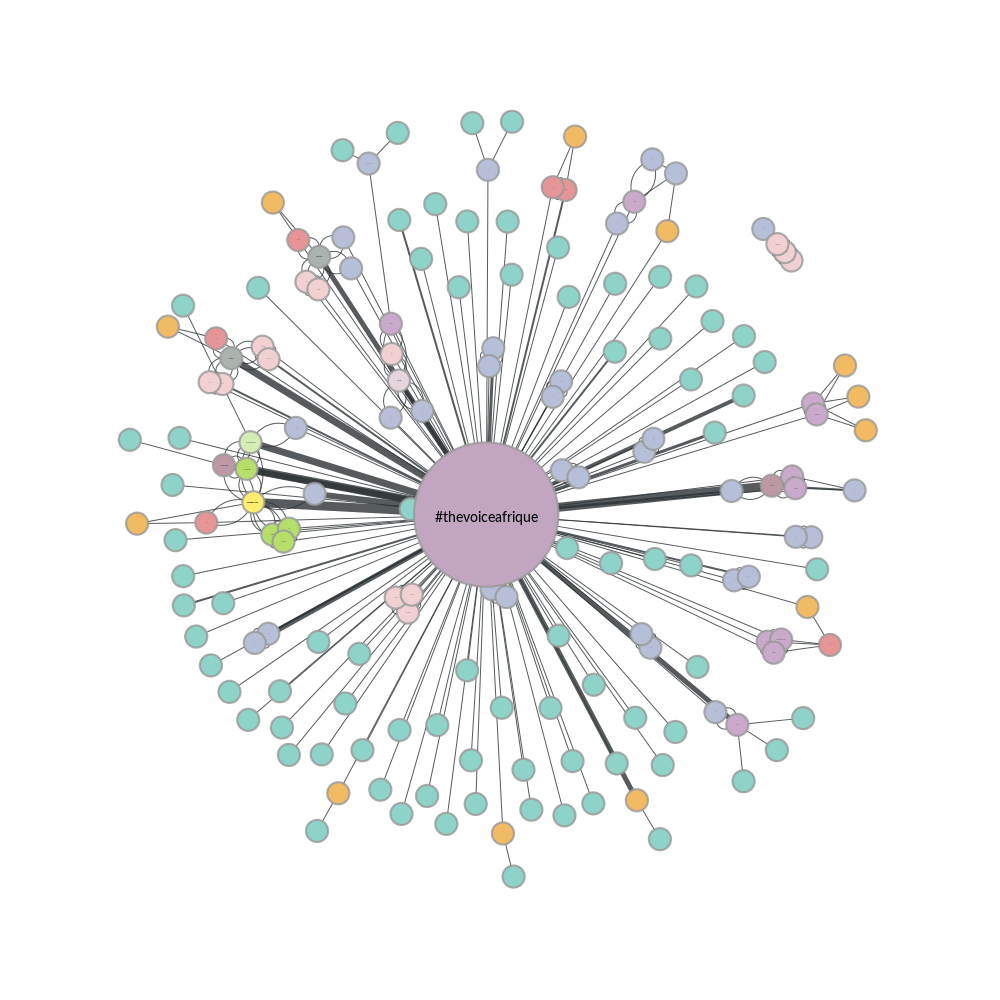

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fa5e4f4d0f0, at 0x7fa5e5433240>

In [15]:
hdeg = hashtag_net.degree_property_map("total")
hvbet, hebet = gt.betweenness(hashtag_net)

hlabel = hashtag_net.vertex_properties["label"]
htsize = hashtag_net.new_vertex_property("float")
htsize.a = hdeg.a / 10

hweight = weight_from(hashtag_net, hedges, hlabel)

hconnected = hashtag_net.new_vertex_property("bool")

for v in hashtag_net.vertices():
    hconnected[v] = hdeg[v] == 0

hashtag_net.set_vertex_filter(hconnected, inverted=True)

hpos = gt.arf_layout(hashtag_net)

gt.graph_draw(hashtag_net,
              hpos,
              vertex_text=hlabel,
              vertex_fill_color=hdeg,
              vertex_font_family=font_family,
              vertex_font_size=htsize,
              edge_pen_width=hweight,
              output_size=output_size,
             )

That's all for this post. In the [next](https://dadaromeo.gihub.io/the-voice-tweets-mining-part-3) post, we will explore *topic modeling* a powerful tool to uncover hidden within a corpus of documents. Thanks for following.